In [ ]:
import os
import shutil
import random

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/archive/Original Dataset"
OUTPUT_PATH = "/content/drive/MyDrive/archive/Splitted Dataset"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


In [ ]:
def create_dirs(output_path):
    for split in ["train", "val", "test"]:
        split_path = os.path.join(output_path, split)
        os.makedirs(split_path, exist_ok=True)

create_dirs(OUTPUT_PATH)


In [ ]:
def split_dataset(dataset_path, output_path, train_ratio, val_ratio):
    classes = os.listdir(dataset_path)

    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)

        total = len(images)
        train_size = int(total * train_ratio)
        val_size = int(total * val_ratio)

        train_images = images[:train_size]
        val_images = images[train_size:train_size+val_size]
        test_images = images[train_size+val_size:]

        for split, img_list in zip(["train", "val", "test"], [train_images, val_images, test_images]):
            split_cls_path = os.path.join(output_path, split, cls)
            os.makedirs(split_cls_path, exist_ok=True)

            for img in img_list:
                shutil.copy(os.path.join(cls_path, img), os.path.join(split_cls_path, img))

split_dataset(DATASET_PATH, OUTPUT_PATH, train_ratio, val_ratio)
print("Dataset successfully split into train, val, and test sets!")


Dataset successfully split into train, val, and test sets!


In [ ]:
for split in ["train", "val", "test"]:
    split_path = os.path.join(OUTPUT_PATH, split)
    print(f"{split.upper()} SET:")
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        print(f"  {cls}: {len(os.listdir(cls_path))} images")


TRAIN SET:
  Bacterial spot rot: 44 images
  No disease: 118 images
  Black Rot: 10 images
  Downy Mildew: 81 images
VAL SET:
  Bacterial spot rot: 9 images
  No disease: 25 images
  Black Rot: 2 images
  Downy Mildew: 17 images
TEST SET:
  Bacterial spot rot: 11 images
  No disease: 27 images
  Black Rot: 3 images
  Downy Mildew: 19 images


In [ ]:
!pip install timm torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = ImageFolder('/content/drive/MyDrive/archive/Splitted Dataset/train', transform=transform)
val_dataset = ImageFolder('/content/drive/MyDrive/archive/Splitted Dataset/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import timm


class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()

        self.effnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        self.effnet_fc = nn.Linear(1280, 1000)

        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.vit_fc = nn.Linear(768, 768)

        self.fc = nn.Linear(1000 + 768, num_classes)

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)

        eff_out = self.effnet(x)
        eff_out = self.effnet_fc(eff_out)

        vit_out = self.vit(x)
        vit_out = self.vit_fc(vit_out)

        fused_out = torch.cat((eff_out, vit_out), dim=1)
        return self.fc(fused_out)

num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(num_classes).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


Epoch [1/5], Loss: 2.4219
Epoch [2/5], Loss: 0.4498
Epoch [3/5], Loss: 0.1651
Epoch [4/5], Loss: 0.1849
Epoch [5/5], Loss: 0.3243


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move inputs and labels to same device as model
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')



Validation Accuracy: 98.11%


In [ ]:
torch.save(model.state_dict(), "efficientnet_vit_hybrid.pth")


<ipython-input-11-fb9f7d836251>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("efficientnet_vit_hybrid.pth", map_location=device))


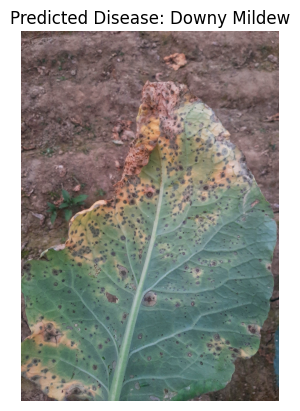

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridModel(num_classes=len(train_dataset.classes)).to(device)
model.load_state_dict(torch.load("efficientnet_vit_hybrid.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def predict_disease(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_class = torch.max(output, 1)

    class_name = train_dataset.classes[predicted_class.item()]

    plt.imshow(img)
    plt.title(f"Predicted Disease: {class_name}")
    plt.axis('off')  # Hide axis
    plt.show()

    return class_name

image_path = "/content/drive/MyDrive/archive/Original Dataset/Downy Mildew/Downy Mildew. (10).jpeg"
predicted_disease = predict_disease(image_path)
print(f"Predicted Disease: {predicted_disease}")


<ipython-input-14-42a7153c52e2>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/efficientnet_vit_hybrid.pth", map_location=devic

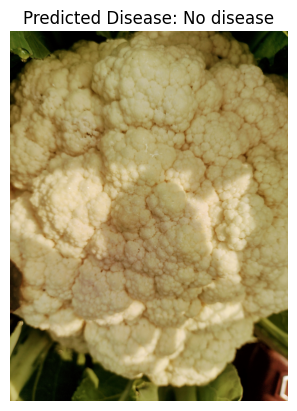

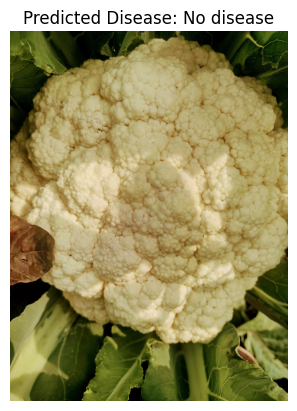

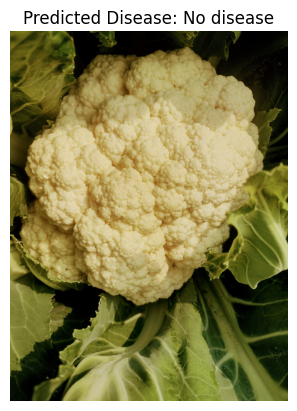

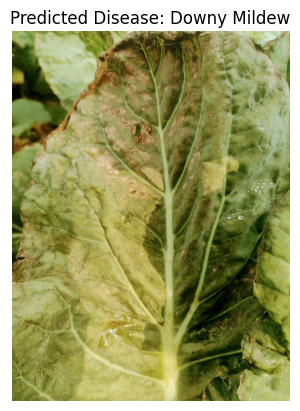

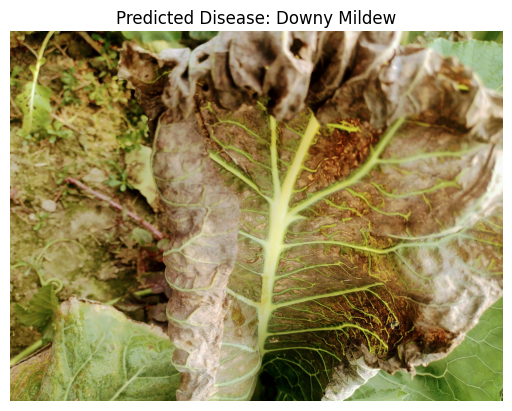

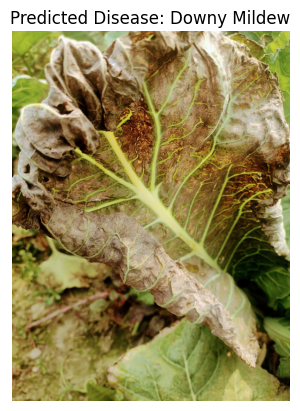

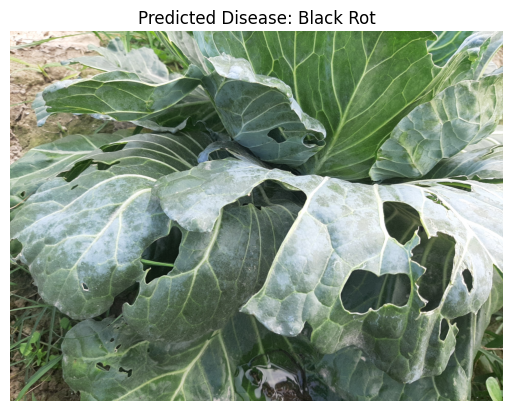

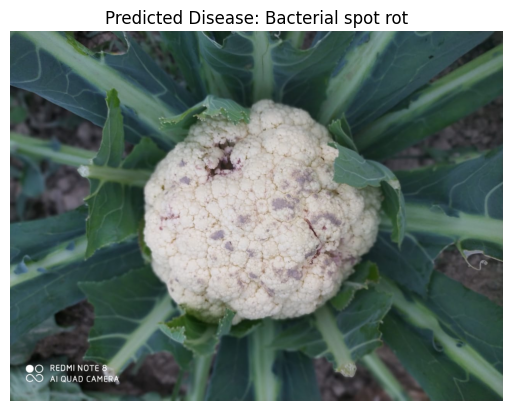

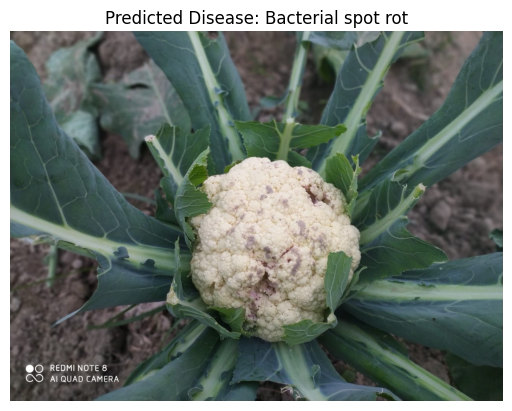

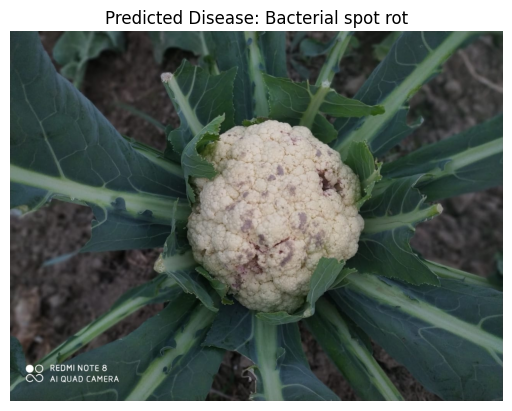

No disease. (68).jpg: No disease
No disease. (67).jpg: No disease
No disease. (66).jpg: No disease
Downy Mildew. (53).jpg: Downy Mildew
Downy Mildew. (52).jpg: Downy Mildew
Downy Mildew. (51).jpg: Downy Mildew
Black Rot(1).jpg: Black Rot
Bacterial Spot. (161).jpg: Bacterial spot rot
Bacterial Spot. (163).jpg: Bacterial spot rot
Bacterial Spot. (162).jpg: Bacterial spot rot


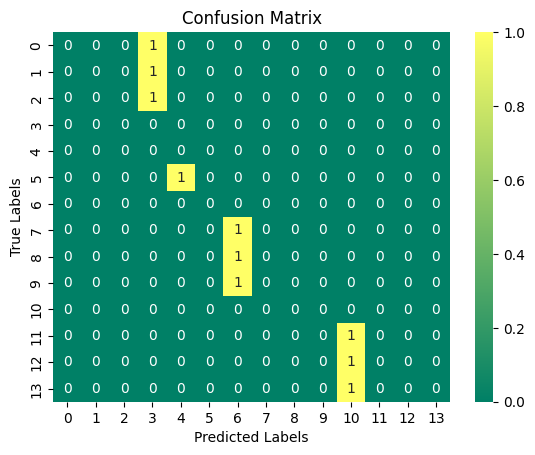

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridModel(num_classes=len(train_dataset.classes)).to(device)
model.load_state_dict(torch.load("/content/efficientnet_vit_hybrid.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def predict_disease(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_class = torch.max(output, 1)

    return train_dataset.classes[predicted_class.item()]

def predict_folder(folder_path):
    results = {}
    y_true = []
    y_pred = []
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        if os.path.isfile(image_path) and image_name.lower().endswith(('png', 'jpg', 'jpeg')):
            predicted_class = predict_disease(image_path)
            results[image_name] = predicted_class

            true_class = image_name.split('_')[0]
            y_true.append(true_class)
            y_pred.append(predicted_class)

            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Predicted Disease: {predicted_class}")
            plt.axis('off')
            plt.show()

    return results, y_true, y_pred

folder_path = "/content/drive/MyDrive/test"
predictions, y_true, y_pred = predict_folder(folder_path)

for img_name, pred in predictions.items():
    print(f"{img_name}: {pred}")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="summer", annot=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
